In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

## Creating a GPU device for PyTorch
- create the GPU device
- store the device in a variable for later use

In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  
print(device)

cpu


## Load data set
- load the dataset
- slice data into a column vector

In [3]:
data_as_np = np.loadtxt("lorenz.txt")
data = torch.from_numpy(data_as_np).to(device).reshape(-1,1)

## Defining the neural network
We must define the neural network as a subclass to the nn.Module

Configure model hyper params

In [4]:
hidden_layer_dim = 100
input_dim = 1
learning_rate = .001
num_epochs = 5
k = 20 # forecasting horizon

Define the neural network
- hidden layer
- sigmoid act fxn
- linear output layer

In [5]:
class My_Neural_Network(nn.Module):
    def __init__(self,input_dim,hidden_layer_dim):
        super(My_Neural_Network, self).__init__()
        self.input_dim = input_dim
        self.hidden_layer_dim = hidden_layer_dim
        self.model = nn.Sequential(
         nn.Linear(self.input_dim,self.hidden_layer_dim), # Hidden layer
         nn.Sigmoid(),   
         nn.Linear(self.hidden_layer_dim,self.hidden_layer_dim), # Hidden layer
         nn.Sigmoid(),   
         nn.Linear(self.hidden_layer_dim,1) # Output layer      
        )

    def forward(self, x):
        return self.model(x) # Run through sequential model
    def printVars(self):
        print("Input : " , self.input_dim)
        print("Hidden layer ", self.hidden_layer_dim)

create the model, loss function (MSE) and optimizer (grad descent)

In [6]:
model = My_Neural_Network(input_dim = input_dim , hidden_layer_dim = hidden_layer_dim).double().to(device)
loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
def train_loop(data, model, loss_fn, optimizer):
    for i in range(data.size(dim=0)-k):
        
        # Compute prediction and loss
        pred = model(data[i])
        loss = loss_fn(pred, data[i+k])

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model

In [8]:
model = train_loop(data,model,loss_fn,optimizer)

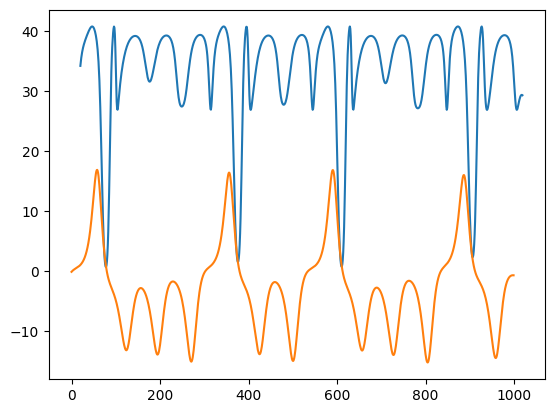

In [9]:
num_pts = 1000
x_axis = range(0,num_pts)
shifted_x_axis = range(k,k+num_pts)
plt.plot( shifted_x_axis,(model(data).detach().cpu().numpy())[0:num_pts])
plt.plot( x_axis,(data.detach().cpu().numpy())[0:num_pts])

## Considering these results
- they look bad
- they *should* be bad  
  
Consider the waveform function represented by this data set W(x), with only 1 input point the model can't distinguish between a **decreasing** part of the waveform and an **increasing** part of waveform. 

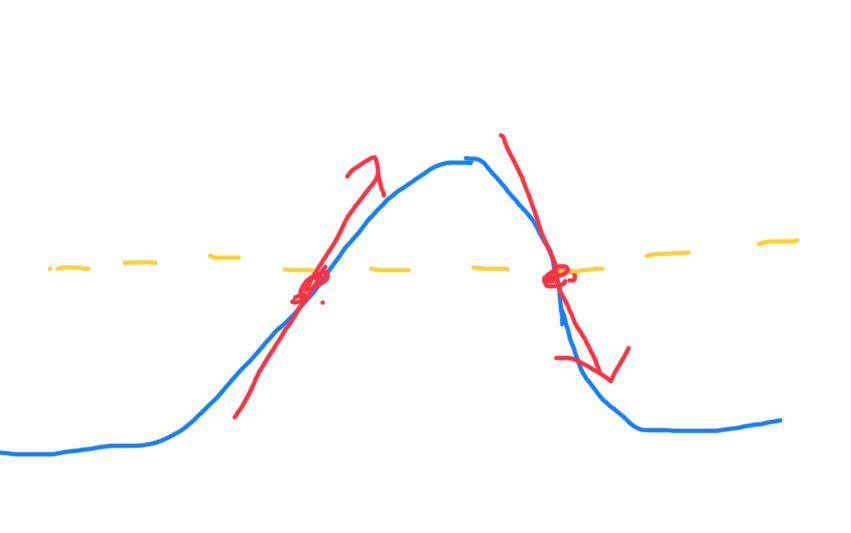

Because the model is **stateless** and **single input** it will give the same prediction for both red points.  
No amount of *overfitting* will solve the face that the input data does not contain sufficent information to make good predictions.

## Improving results

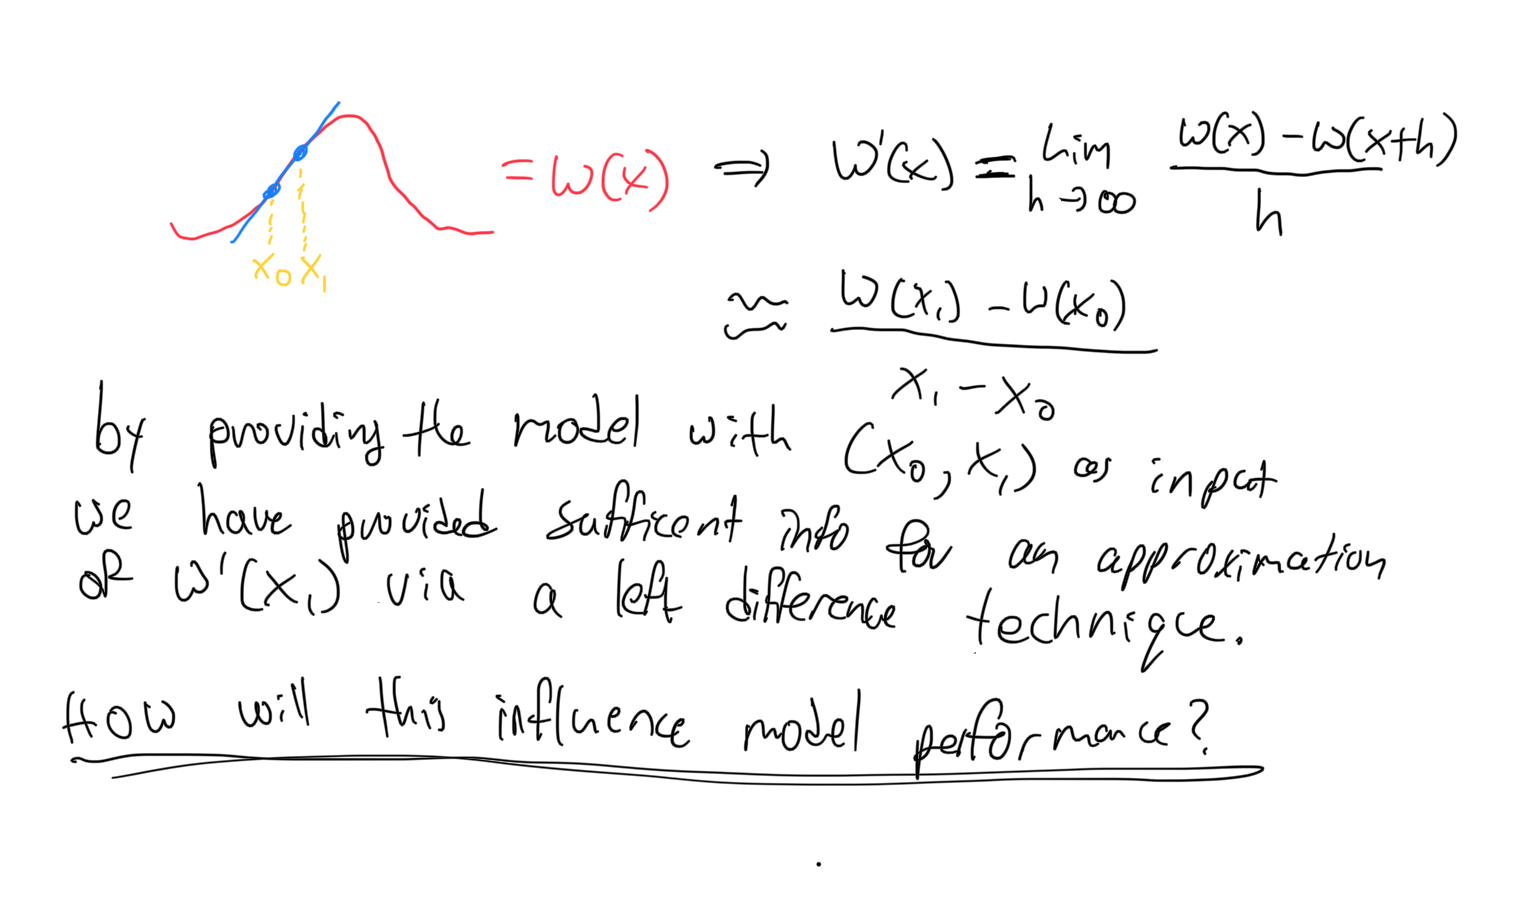

## Transforming the data

In [10]:
# remake data as 2 column
data_list = []
for i in range(0,data.size(0)-1):
    data_list.append([data_as_np[i],data_as_np[i+1]])
data = torch.from_numpy(np.array(data_list)).to(device)

## Constructing the NN
- fully connected feed-forward NN
- sigmoid activation fxn
- now has enough info for a derivative

In [11]:
k = k+1
hidden_layer =200
model = My_Neural_Network(input_dim = 2 , hidden_layer_dim = hidden_layer_dim).double().to(device)
loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
def train_loop_larger_input(data, model, loss_fn, optimizer):
    for i in range(data.size(dim=0)-k):
        
        # Compute prediction and loss
        pred = model(data[i])
        loss = loss_fn(pred, data[i+k][0:1])

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model

In [13]:
model = train_loop_larger_input(data,model,loss_fn,optimizer)

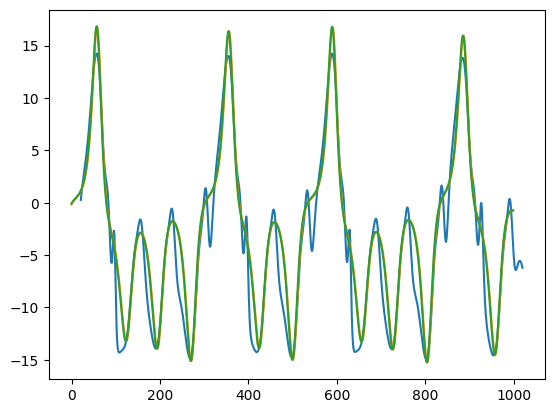

In [14]:
num_pts = 1000
x_axis = range(0,num_pts)
shifted_x_axis = range(k,k+num_pts)
plt.plot( shifted_x_axis,(model(data).detach().cpu().numpy())[0:num_pts])
plt.plot( x_axis,(data.detach().cpu().numpy())[0:num_pts])

- big improvement
- but we can do better

## Stateful NN (RNNs)
- periodic functions (like waveforms) are well approximated by stateful models.

**why?**
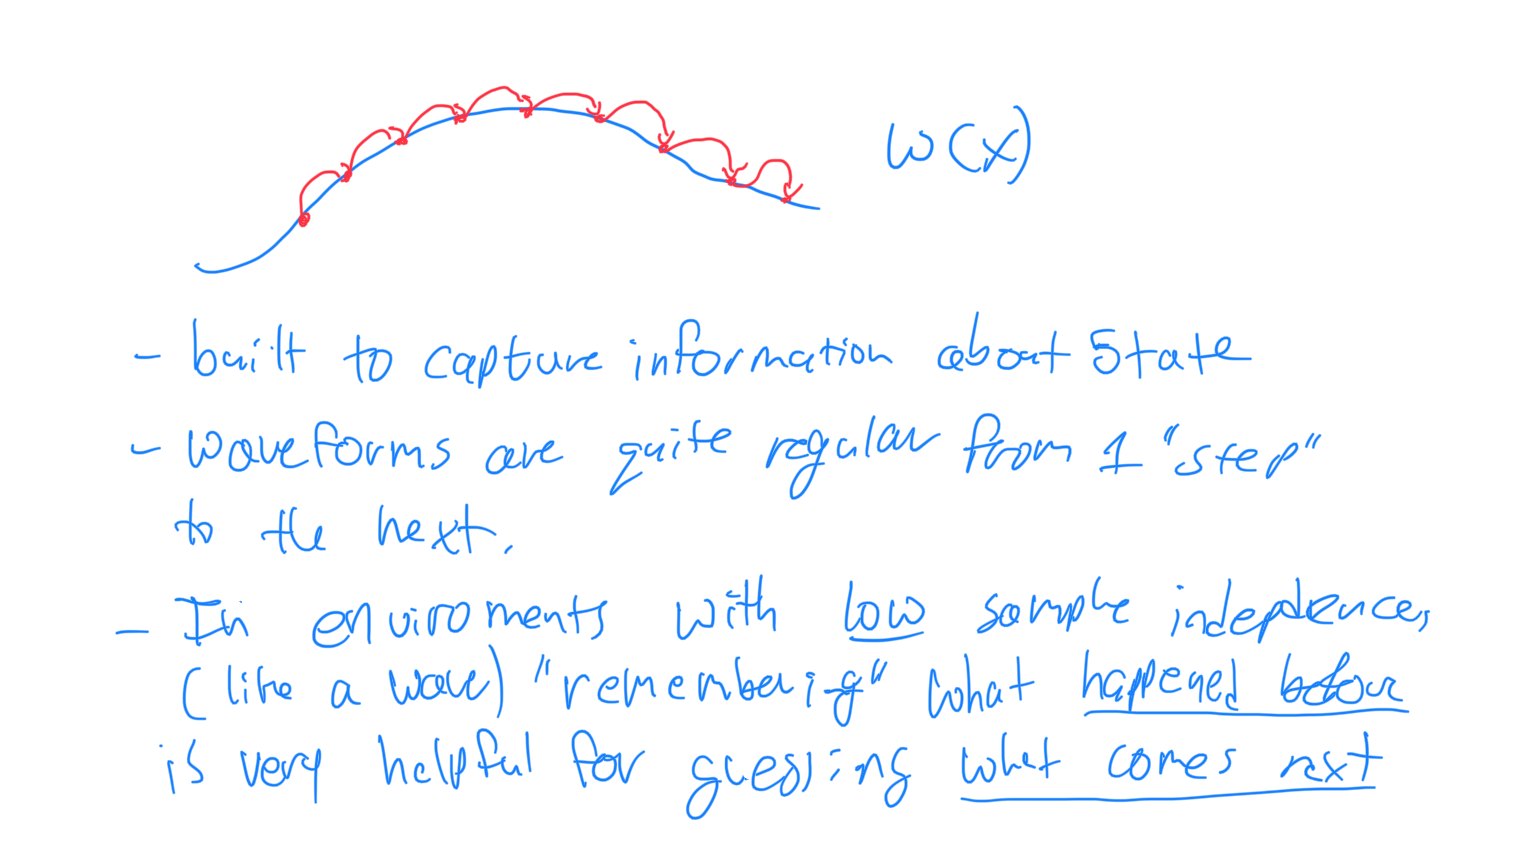

In [21]:
class RNN(nn.Module):
    def __init__(self,input_dim,hidden_layer_dim):
        super(RNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_layer_dim = hidden_layer_dim
        self.model = nn.Sequential(
         nn.LSTM(input_size=self.input_dim,
                 hidden_size = self.hidden_layer_dim,
                 num_layers = 2
                ), # Hidden layer  
         nn.Linear(self.hidden_layer_dim,1) # Output layer      
        )

    def forward(self, x):
        return self.model(x) # Run through sequential model
    def printVars(self):
        print("Input : " , self.input_dim)
        print("Hidden layer ", self.hidden_layer_dim)

In [22]:
k = k+1
model = RNN(input_dim = 2 , hidden_layer_dim = 10).double().to(device)
loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [23]:
model = train_loop(data,model,loss_fn,optimizer)

RuntimeError: input must have 3 dimensions, got 2

In [20]:
print(model)

RNN(
  (model): Sequential(
    (0): LSTM(2, 10, num_layers=2)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
)
